# Librerías

In [12]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import joblib

import a_funciones as fn

In [39]:
# Cargar los datos escalados, la variable de respuesta y el scaler
df_historicos_scaled = joblib.load('salidas/df_historicos_transf.pkl')
y = joblib.load('salidas/v.respuesta.pkl')
sc = joblib.load('salidas/scaler.pkl')


In [34]:
df_historicos_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CreditScore                      10000 non-null  float64
 1   DebtRatio                        10000 non-null  float64
 2   Assets                           10000 non-null  float64
 3   Age                              10000 non-null  float64
 4   NumberOfDependents               10000 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans  10000 non-null  float64
 6   MonthlyIncome                    10000 non-null  float64
 7   NumberOfTimesPastDue             10000 non-null  float64
 8   EmploymentLength                 10000 non-null  float64
 9   YearsAtCurrentAddress            10000 non-null  float64
 10  HomeOwnership_Mortgage           10000 non-null  float64
 11  HomeOwnership_Own                10000 non-null  float64
 12  HomeOwnership_Rent 

In [16]:
df_new_credit = pd.read_csv('data/datos_nuevos_creditos.csv')
df_new_credit.head()

,ID,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,HomeOwnership,Education,MaritalStatus,YearsAtCurrentAddress,NewLoanApplication
0,10001,737,0.479047,34979,63,6,12,2904,8,15,Mortgage,High School,Widowed,20,37752.0
1,10002,411,0.442930,56459,28,7,4,17639,11,4,Rent,High School,Widowed,21,52917.0
2,10003,732,0.532314,76570,26,5,8,17730,7,10,Rent,High School,Widowed,10,106380.0
3,10004,710,0.295541,86752,51,8,16,7166,16,18,Mortgage,Masters,Widowed,17,35830.0
4,10005,848,0.248378,102286,29,4,8,4688,16,1,Own,High School,Widowed,26,32816.0


In [17]:
df_new_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               1058 non-null   int64  
 1   CreditScore                      1058 non-null   int64  
 2   DebtRatio                        1058 non-null   float64
 3   Assets                           1058 non-null   int64  
 4   Age                              1058 non-null   int64  
 5   NumberOfDependents               1058 non-null   int64  
 6   NumberOfOpenCreditLinesAndLoans  1058 non-null   int64  
 7   MonthlyIncome                    1058 non-null   int64  
 8   NumberOfTimesPastDue             1058 non-null   int64  
 9   EmploymentLength                 1058 non-null   int64  
 10  HomeOwnership                    1058 non-null   object 
 11  Education                        1058 non-null   object 
 12  MaritalStatus       

In [18]:
monto_credito = df_new_credit['NewLoanApplication']

In [19]:
del df_new_credit['NewLoanApplication']
del df_new_credit['ID']

In [20]:
df_new_credit.head()

,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,HomeOwnership,Education,MaritalStatus,YearsAtCurrentAddress
0,737,0.479047,34979,63,6,12,2904,8,15,Mortgage,High School,Widowed,20
1,411,0.442930,56459,28,7,4,17639,11,4,Rent,High School,Widowed,21
2,732,0.532314,76570,26,5,8,17730,7,10,Rent,High School,Widowed,10
3,710,0.295541,86752,51,8,16,7166,16,18,Mortgage,Masters,Widowed,17
4,848,0.248378,102286,29,4,8,4688,16,1,Own,High School,Widowed,26


In [38]:
df_newcredit, _ = fn.procesar_datos(df_new_credit, scaler=sc)
df_newcredit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CreditScore                      1058 non-null   float64
 1   DebtRatio                        1058 non-null   float64
 2   Assets                           1058 non-null   float64
 3   Age                              1058 non-null   float64
 4   NumberOfDependents               1058 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans  1058 non-null   float64
 6   MonthlyIncome                    1058 non-null   float64
 7   NumberOfTimesPastDue             1058 non-null   float64
 8   EmploymentLength                 1058 non-null   float64
 9   YearsAtCurrentAddress            1058 non-null   float64
 10  HomeOwnership_Mortgage           1058 non-null   float64
 11  HomeOwnership_Own                1058 non-null   float64
 12  HomeOwnership_Rent  

In [ ]:
X = df_historicos_scaled
# Segmentación con K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df_historicos_scaled['Segmento'] = kmeans.fit_predict(X)

# Entrenar modelo de Random Forest para cada segmento
modelos = {}
for segmento in df_historicos_scaled['Segmento'].unique():
    # Filtrar datos por segmento
    datos_segmento = df_historicos_scaled[df_historicos_scaled['Segmento'] == segmento]
    X_segmento = datos_segmento.drop(columns=['NoPaidPerc', 'Segmento'])  # Asegúrate de que 'NoPaidPerc' no esté
    y_segmento = datos_segmento['NoPaidPerc']  # Variable de respuesta

    # Entrenar modelo de Random Forest para el segmento
    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo.fit(X_segmento, y_segmento)
    modelos[segmento] = modelo

# Para predecir para un nuevo cliente, se debe escalar y predecir
nuevo_cliente = df_new_credit.iloc[0]  # Obtén los datos del nuevo cliente
nuevo_cliente_scaled = sc.transform([nuevo_cliente])  # Escalar las características del nuevo cliente

# Predecir el segmento para el nuevo cliente
segmento_cliente = kmeans.predict(nuevo_cliente_scaled)[0]

# Predecir el riesgo para el nuevo cliente
riesgo_predicho = modelos[segmento_cliente].predict(nuevo_cliente_scaled)

print(f"Riesgo predicho para el nuevo cliente: {riesgo_predicho}")

In [40]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_historicos_scaled['Segmento'] = kmeans.fit_predict(df_historicos_scaled)

modelos = {}
for segmento in df_historicos_scaled['Segmento'].unique():
    datos_segmento = df_historicos_scaled[df_historicos_scaled['Segmento'] == segmento]
    X_segmento = datos_segmento.drop(columns=['Segmento'])
    y_segmento = y[datos_segmento.index]
    
    modelo = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo.fit(X_segmento, y_segmento)
    
    modelos[segmento] = modelo

nuevo_cliente = df_newcredit.iloc[0]
segmento_cliente = kmeans.predict([nuevo_cliente])[0]
riesgo_predicho = modelos[segmento_cliente].predict([nuevo_cliente])

print(f"El segmento del nuevo cliente es: {segmento_cliente}")
print(f"El riesgo predicho para el cliente es: {riesgo_predicho}")

El segmento del nuevo cliente es: 0
El riesgo predicho para el cliente es: [0.15585453]


c:\Users\Manuela\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\Manuela\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [43]:
df_historicos_scaled.head()

,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,MonthlyIncome,NumberOfTimesPastDue,EmploymentLength,YearsAtCurrentAddress,...,HomeOwnership_Rent,Education_Bachelor,Education_High School,Education_Masters,Education_PhD,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,Segmento
0,0.153005,0.016528,0.099691,0.028169,0.000000,0.105263,0.860918,0.473684,0.965517,0.620690,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,0.393443,0.138818,0.016119,0.394366,0.555556,0.421053,0.325016,0.684211,0.000000,0.310345,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,0.615665,0.391192,0.591818,0.873239,0.555556,0.368421,0.047852,0.315789,0.862069,0.310345,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.114754,0.463579,0.108542,0.507042,1.000000,0.000000,0.965361,0.263158,0.758621,0.103448,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2
4,0.918033,0.504890,0.102869,0.760563,0.111111,0.526316,0.364656,0.947368,0.655172,0.172414,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2


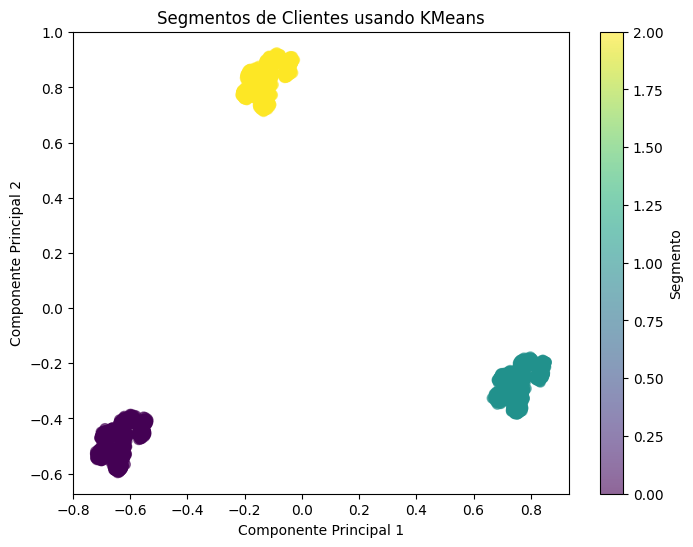

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Aplicar PCA para reducir las dimensiones a 2
pca = PCA(n_components=2)
df_historicos_scaled_pca = pca.fit_transform(df_historicos_scaled.drop(columns=['Segmento']))

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(df_historicos_scaled_pca[:, 0], df_historicos_scaled_pca[:, 1], c=df_historicos_scaled['Segmento'], cmap='viridis', s=50, alpha=0.6)

# Añadir etiquetas y título
plt.title('Segmentos de Clientes usando KMeans')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Mostrar la leyenda de los segmentos
plt.colorbar(label='Segmento')

# Mostrar el gráfico
plt.show()